Baseline Cox model looking at survival but excluding images.


In [ ]:
import pandas as pd
#!pip install lifelines
from lifelines import CoxPHFitter
#!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
from lifelines import CoxPHFitter


# Load and select relevant columns
df = pd.read_csv("/rds/general/user/dla24/home/thesis/TGCA_dataset/df_clean.csv")
df = df.drop(columns=["vital_status"])
# Keep only rows with complete clinical info
df_clinical = df[["os_days", "event", "age_at_diagnosis_years", "tumour_grade", "tumour_stage"]].dropna()


In [4]:
cph = CoxPHFitter()
cph.fit(df_clinical, duration_col="os_days", event_col="event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 411 total observations, 291 right-censored observations>
             duration col = 'os_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 411
number of events observed = 120
   partial log-likelihood = -598.17
         time fit was run = 2025-07-11 08:25:00 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
age_at_diagnosis_years  0.04      1.04      0.01            0.03            0.06                1.03                1.06
tumour_grade            0.35      1.42      0.14            0.07            0.63                1.07                1.87
tumour_stage            0.51      1.66      0.09            0.33            0.69                1.38                2.00

                        cmp to    z      p  -log2(p)
covariate                                           
age_at_diagnosis_years    0.00 4.87 <0.005     19.79
tumour_grade              0.00 2.43   0.02      6.06
tumour_stage              0.00 5.45 <0.005     24.24
---
Concordance = 0.76
Partial AIC = 1202.33
log-likelihood ratio test = 89.47 on 3 df
-log2(p) of ll-ratio test = 61.61

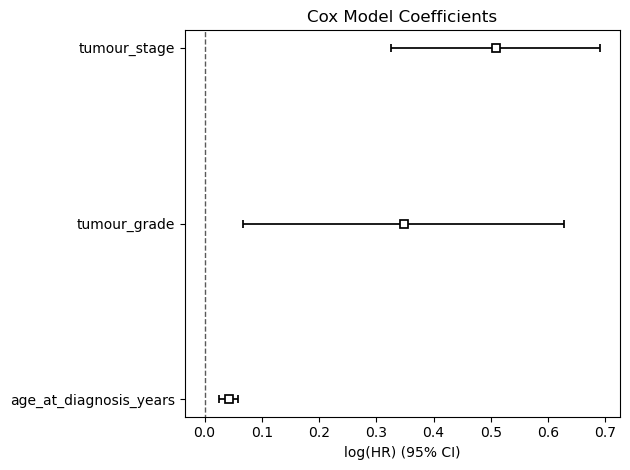

In [5]:
import matplotlib.pyplot as plt

cph.plot()
plt.title("Cox Model Coefficients")
plt.tight_layout()
plt.show()

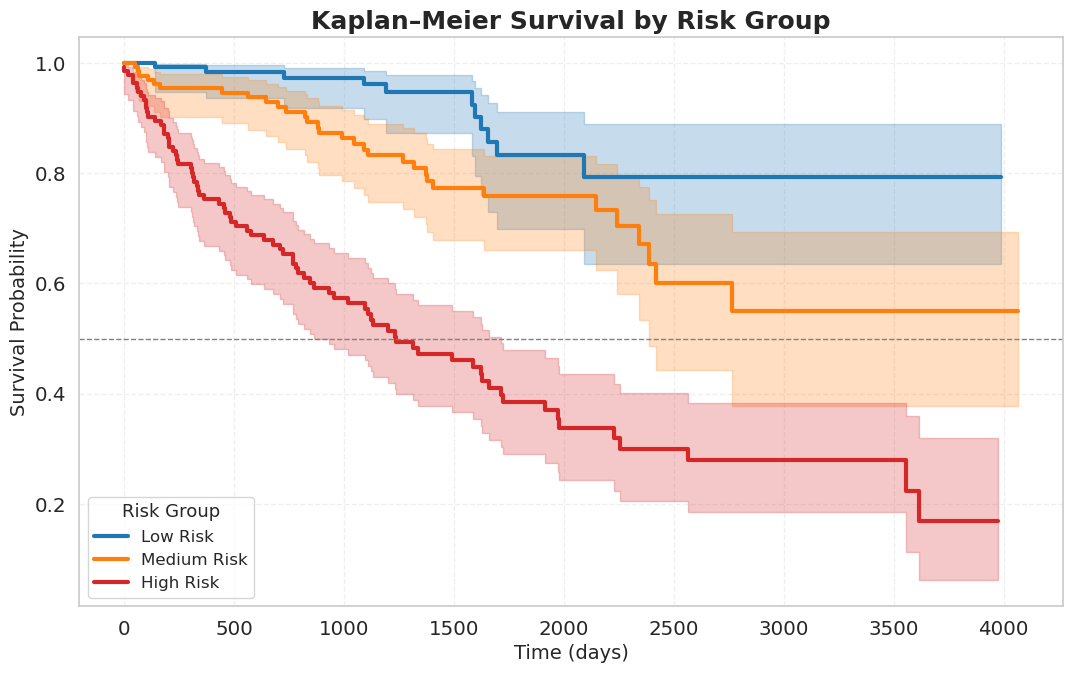

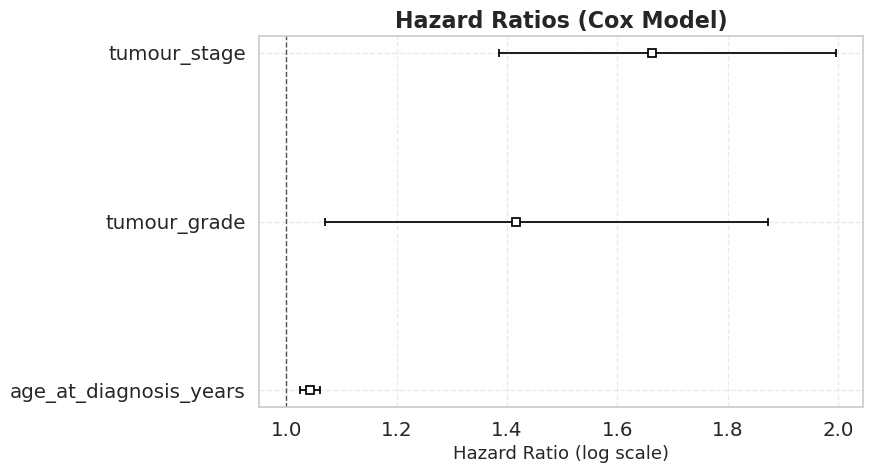

Median survival time: 1238.0
Survival probability at 1 year: 0.7526264806333617


In [ ]:
from lifelines import KaplanMeierFitter
import seaborn as sns 

# Predict risk and stratify
df["risk_score"] = cph.predict_partial_hazard(df)
df["risk_group"] = pd.qcut(df["risk_score"], q=3, labels=["Low", "Medium", "High"])

# Color palette
palette = {"Low": "#1f77b4", "Medium": "#ff7f0e", "High": "#d62728"}
sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

# KM CURVE BY RISK GROUP

plt.figure(figsize=(11, 7))
kmf = KaplanMeierFitter()
for group in ["Low", "Medium", "High"]:
    ix = df["risk_group"] == group
    kmf.fit(df.loc[ix, "os_days"], event_observed=df.loc[ix, "event"], label=f"{group} Risk")
    kmf.plot(ci_show=True, lw=3, color=palette[group])

plt.title("Kaplan–Meier Survival by Risk Group", fontsize=18, weight='bold')
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.axhline(0.5, c='gray', linestyle='--', lw=1)
plt.legend(title="Risk Group", fontsize=12, title_fontsize=13, loc="lower left", frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# HAZARD RATIO PLOT

plt.figure(figsize=(9, 5))
ax = cph.plot(hazard_ratios=True, linewidth=3)
plt.title("Hazard Ratios (Cox Model)", fontsize=16, weight="bold")
plt.xlabel("Hazard Ratio (log scale)", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


print("Median survival time:", kmf.median_survival_time_)
print("Survival probability at 1 year:", kmf.survival_function_at_times(365).values[0])